In [263]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [264]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [265]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [266]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [267]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.0]) # weight of each state
        return states.sum(dim=0)

In [268]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        while error > eps and epoch <= max_epoch:
            loss = self.step()
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.3f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        print('Landing Trajectory:')
        for r in range(N):
            plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
            plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

[[ 1.14517254e-01  4.96905366e-02  1.76708953e-01  4.66947972e-02
   1.18444141e+00 -1.63175986e-02]
 [-2.62866029e-01  1.06490707e-01 -3.37201216e-01 -1.67152527e-02
   1.36785105e+00 -9.36727458e-02]
 [ 4.64522454e-01 -5.43799829e-02 -1.53451844e-02  1.53580685e-02
   1.13835924e+00 -4.99576755e-02]
 [ 4.35580834e-01 -1.99462512e-02 -6.05594640e-02 -2.78645711e-02
   1.39513467e+00 -1.09275301e-02]
 [-4.89234539e-01 -1.58371372e-02 -2.89663109e-02 -4.54388674e-02
   1.14681613e+00 -9.92323090e-02]
 [-3.88490590e-01  6.37544112e-02 -1.91010599e-01  3.18419387e-03
   1.26832989e+00 -3.20435914e-02]
 [ 1.72431838e-01  9.41567241e-02  4.17777521e-02 -1.04791872e-02
   1.36557285e+00 -9.03053081e-02]
 [-6.44947413e-01  1.13078846e-01 -1.08999405e-01 -3.37161726e-02
   1.07984770e+00 -1.93842338e-02]
 [ 4.88372521e-01  3.99253747e-02 -2.63412220e-01  1.34040448e-02
   1.22735765e+00 -6.75659756e-02]
 [ 5.54064311e-01 -1.63443562e-02  3.23873607e-02  1.68592783e-02
   1.32326680e+00 -9.0905

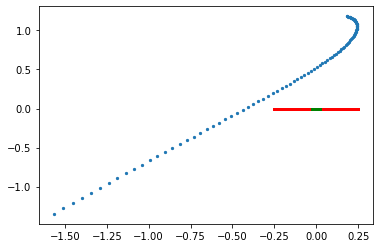

[2] loss: 420.018


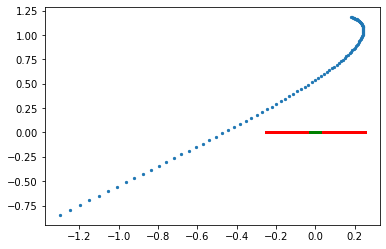

[3] loss: 272.925


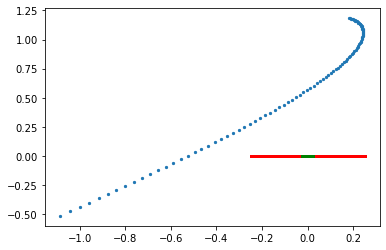

[4] loss: 192.526


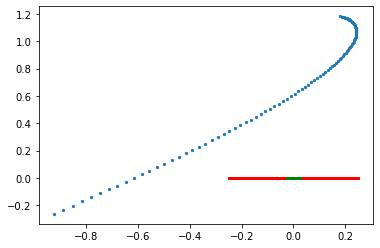

[5] loss: 144.726


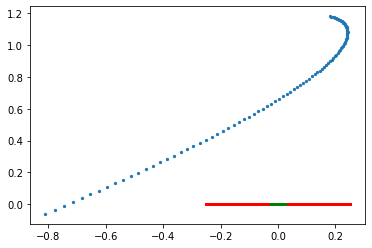

[6] loss: 113.973


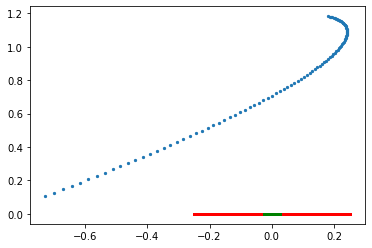

[7] loss: 92.696


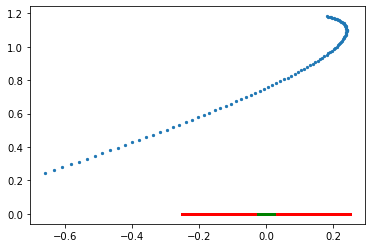

[8] loss: 77.061


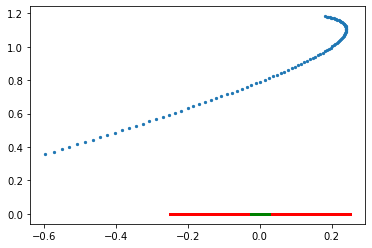

[9] loss: 64.791


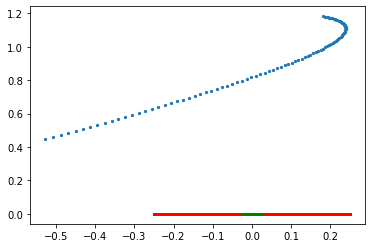

[10] loss: 54.092


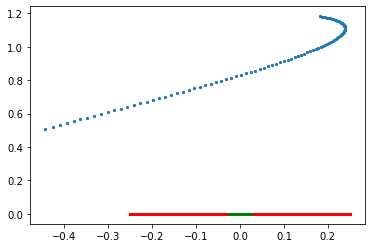

[11] loss: 43.579


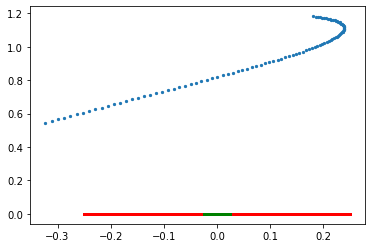

[12] loss: 33.271


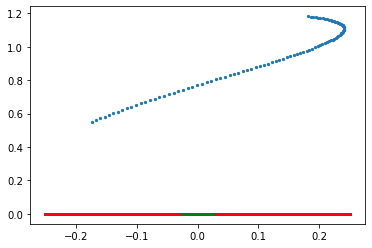

[13] loss: 24.563


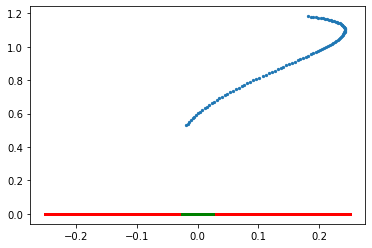

[14] loss: 18.415


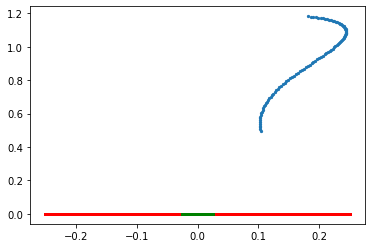

[15] loss: 13.042


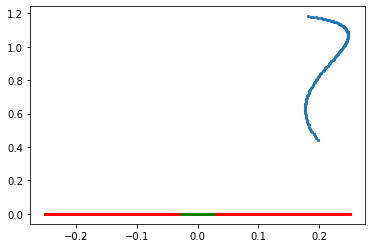

[16] loss: 8.973


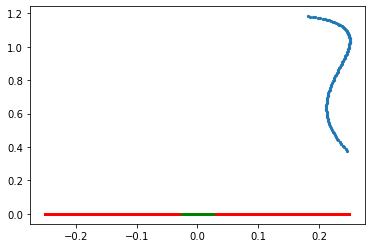

[17] loss: 6.480


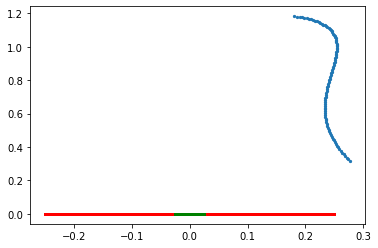

[18] loss: 4.811


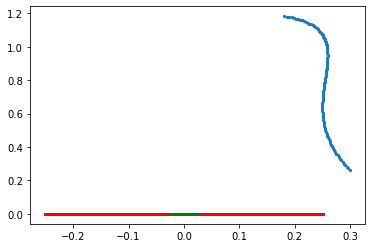

[19] loss: 3.677


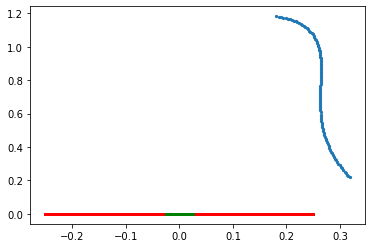

[20] loss: 2.814


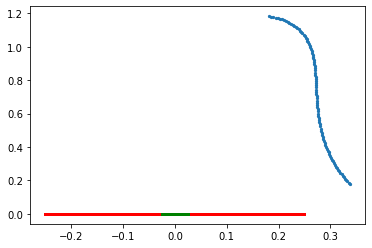

[21] loss: 2.138


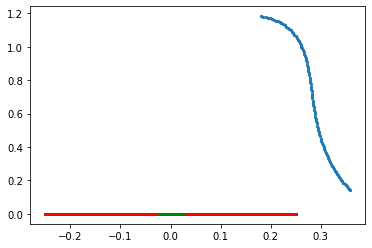

[22] loss: 1.609


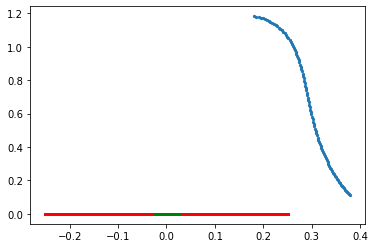

[23] loss: 1.215


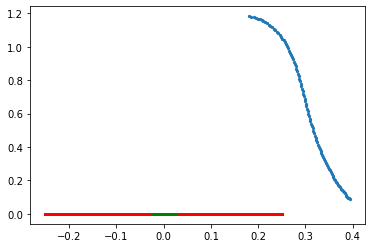

[24] loss: 0.938


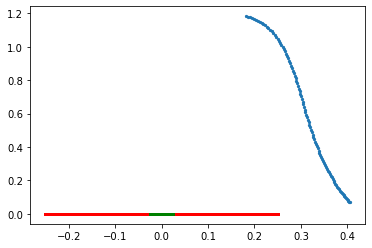

[25] loss: 0.739


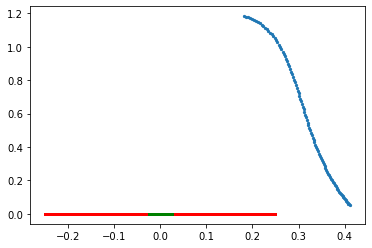

[26] loss: 0.592


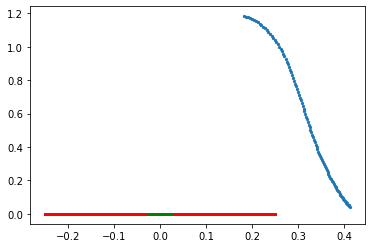

[27] loss: 0.481


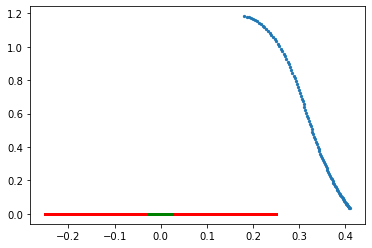

[28] loss: 0.397


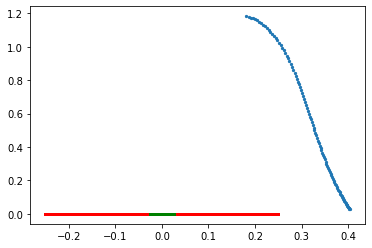

[29] loss: 0.332


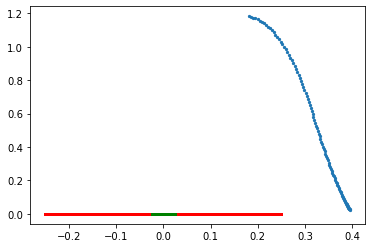

[30] loss: 0.280


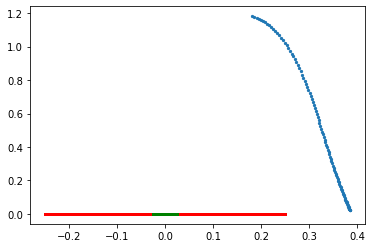

[31] loss: 0.239


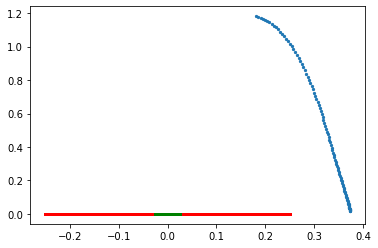

[32] loss: 0.206


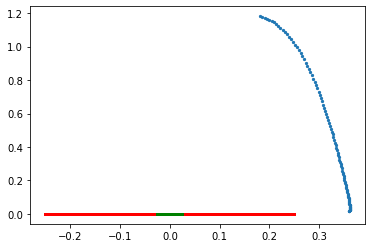

[33] loss: 0.179


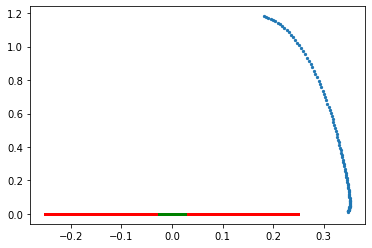

[34] loss: 0.159


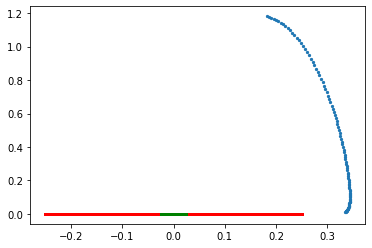

[35] loss: 0.142


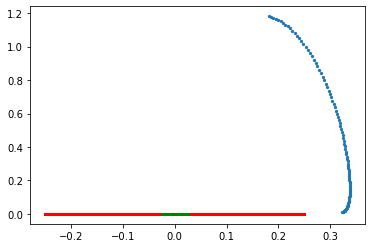

[36] loss: 0.129


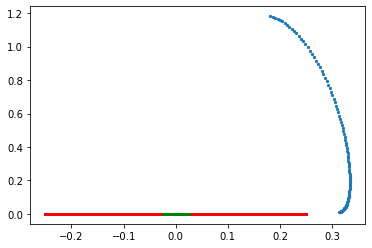

[37] loss: 0.118


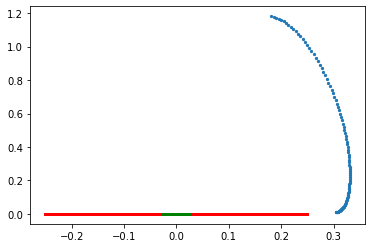

[38] loss: 0.109


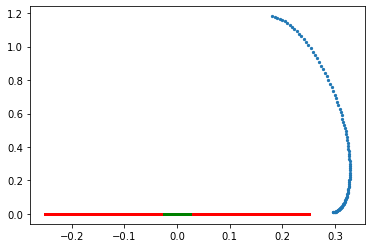

[39] loss: 0.101


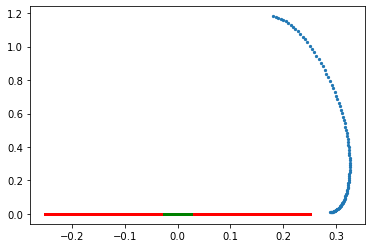

[40] loss: 0.093


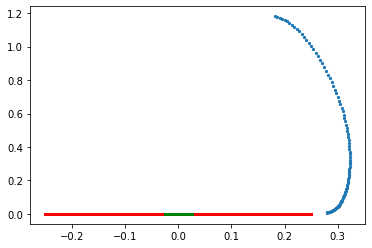

[41] loss: 0.084


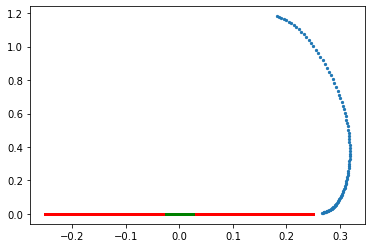

[42] loss: 0.060


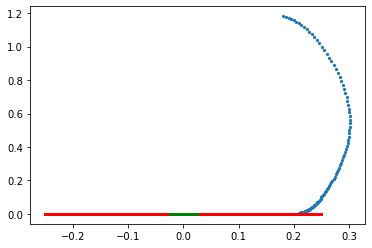

[43] loss: 0.047


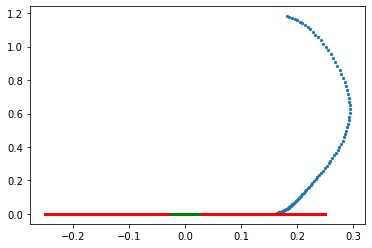

[44] loss: 0.041


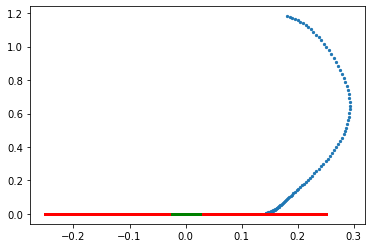

[45] loss: 0.036


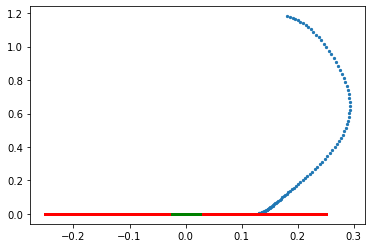

[46] loss: 0.033


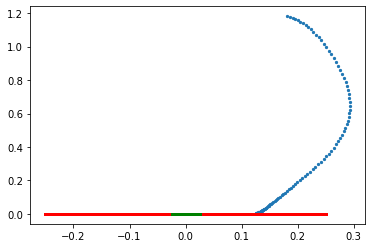

[47] loss: 0.030


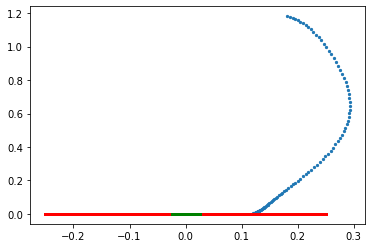

[48] loss: 0.027


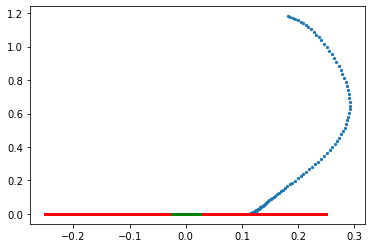

[49] loss: 0.022


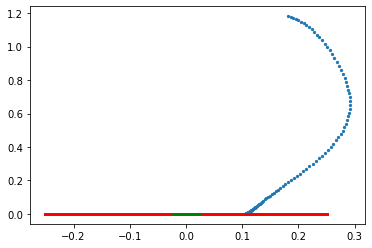

[50] loss: 0.019


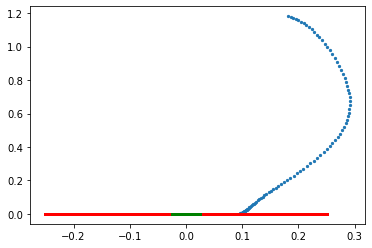

[51] loss: 0.016


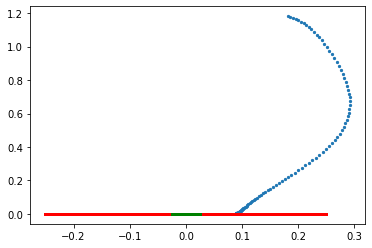

[52] loss: 0.015


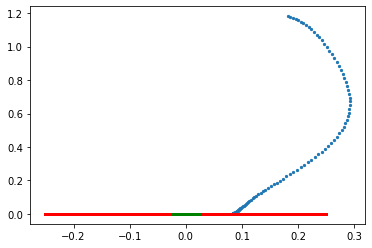

[53] loss: 0.014


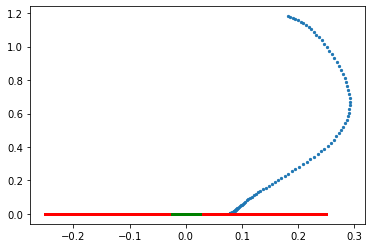

[54] loss: 0.012


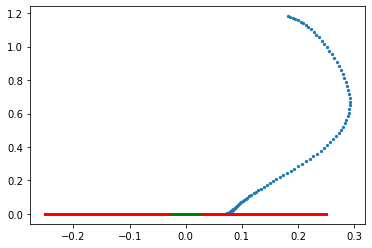

[55] loss: 0.011


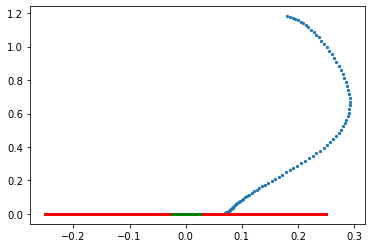

[56] loss: 0.010


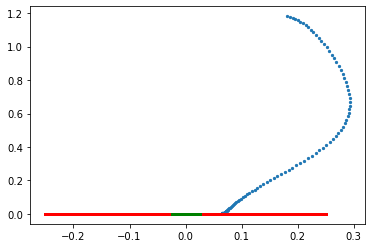

[57] loss: 0.009


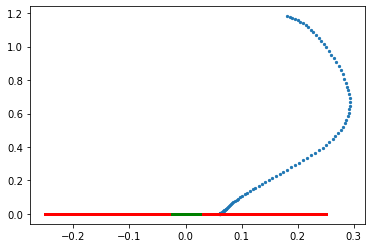

[58] loss: 0.008


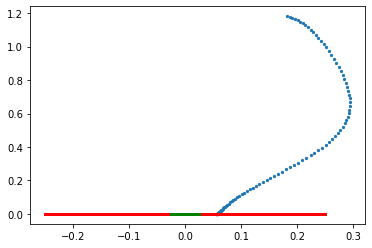

[59] loss: 0.007


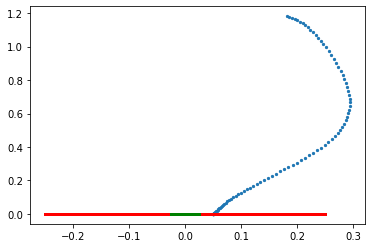

[60] loss: 0.006


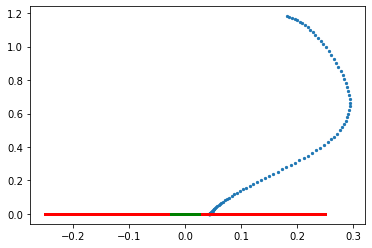

[61] loss: 0.005


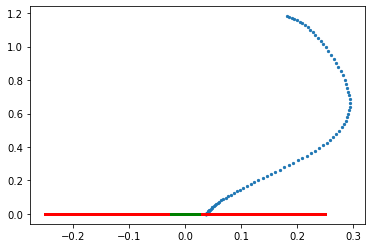

[62] loss: 0.004


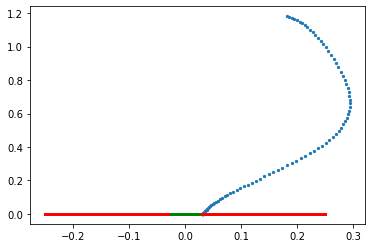

[63] loss: 0.004


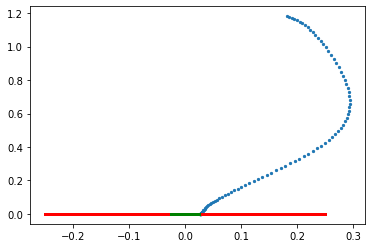

[64] loss: 0.003


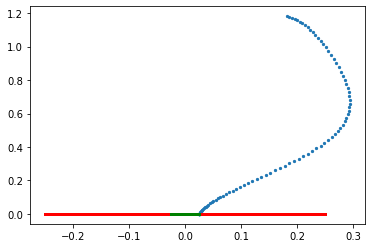

[65] loss: 0.003


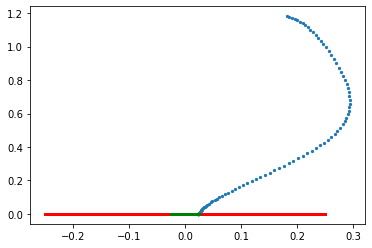

[66] loss: 0.003


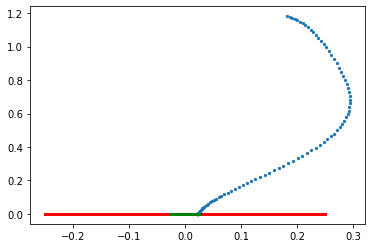

[67] loss: 0.003


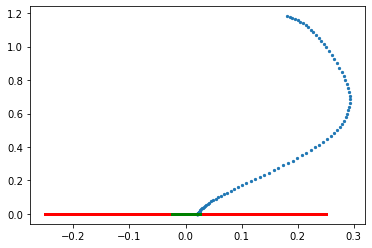

[68] loss: 0.002


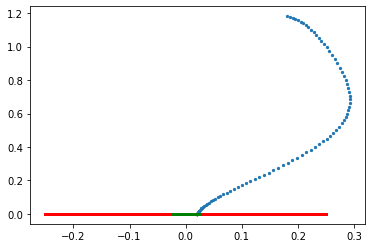

[69] loss: 0.002


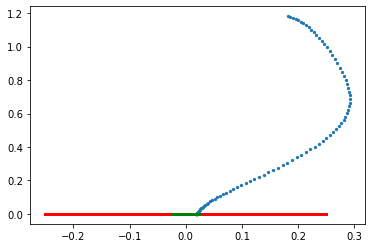

[70] loss: 0.002


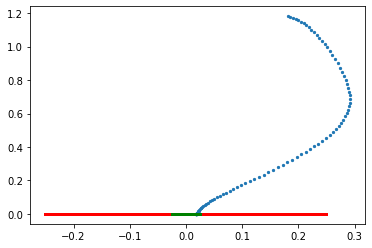

[71] loss: 0.002


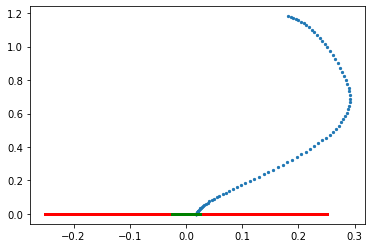

[72] loss: 0.002


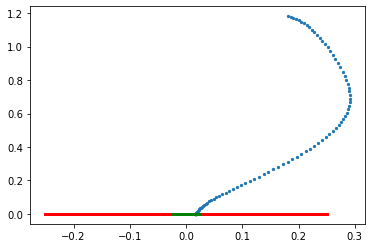

[73] loss: 0.002


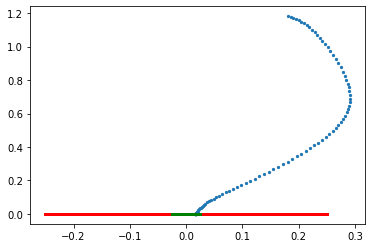

[74] loss: 0.002


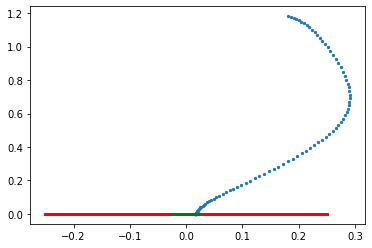

[75] loss: 0.001


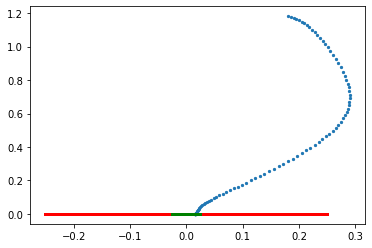

[76] loss: 0.001


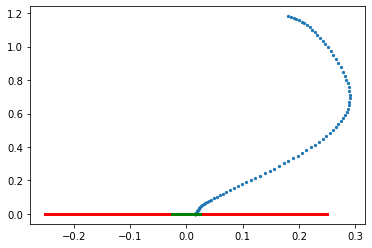

[77] loss: 0.001


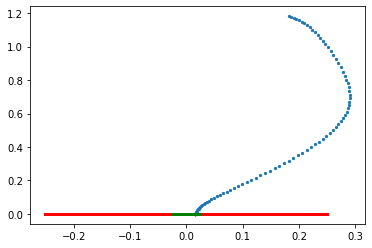

[78] loss: 0.001


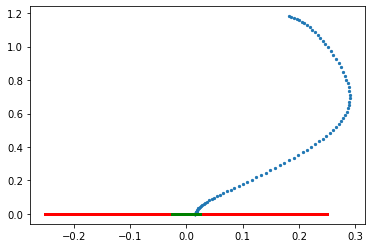

[79] loss: 0.001


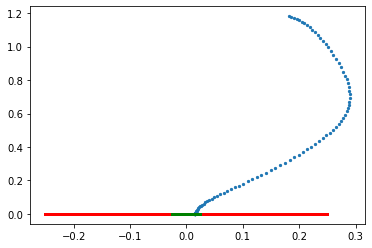

[80] loss: 0.001


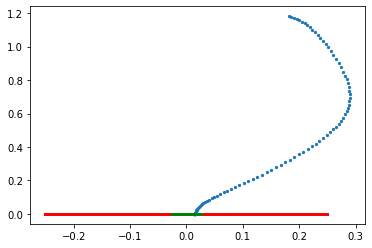

[81] loss: 0.001


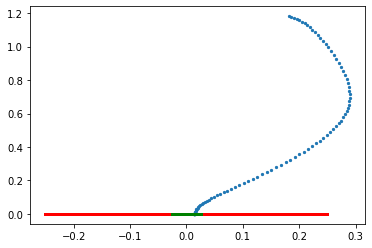

[82] loss: 0.001


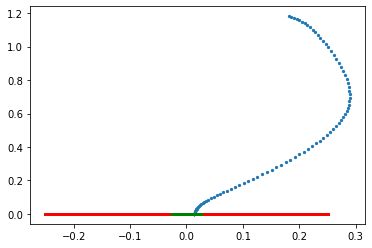

[83] loss: 0.001


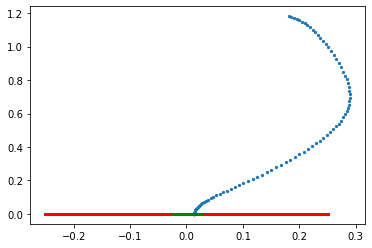

[84] loss: 0.001


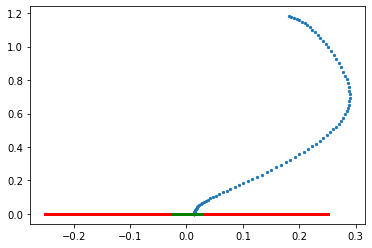

[85] loss: 0.001


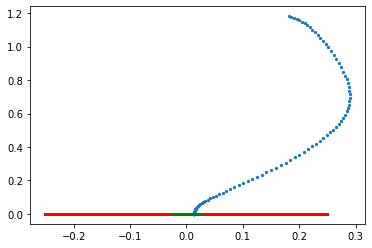

[86] loss: 0.001


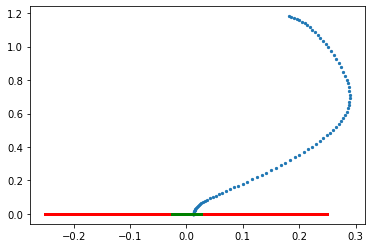

[87] loss: 0.001


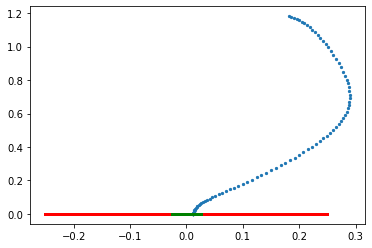

[88] loss: 0.001


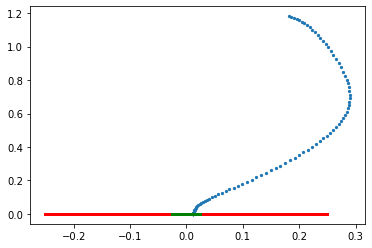

[89] loss: 0.001


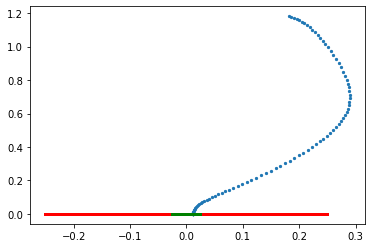

[90] loss: 0.001


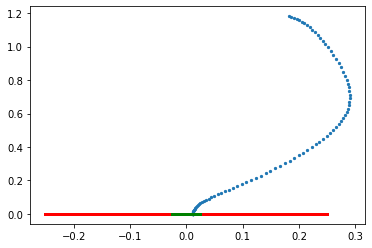

[91] loss: 0.001


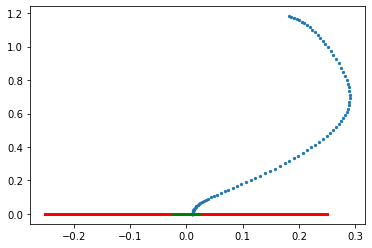

[92] loss: 0.001


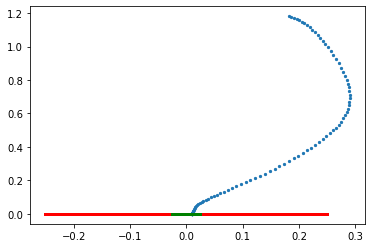

[93] loss: 0.000


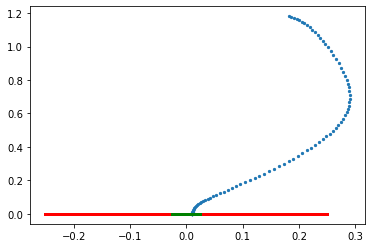

[94] loss: 0.000


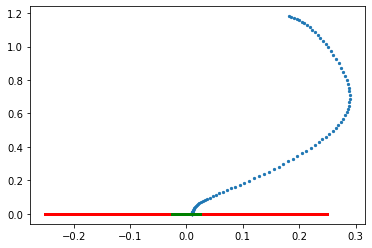

[95] loss: 0.000


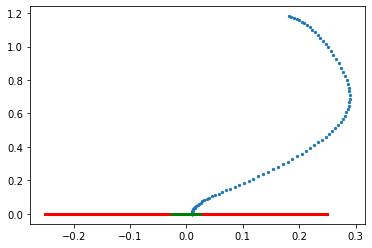

[96] loss: 0.000


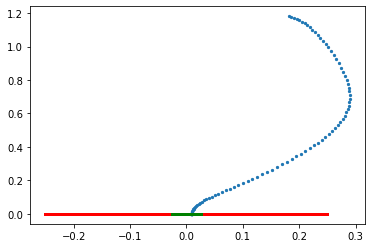

[97] loss: 0.000


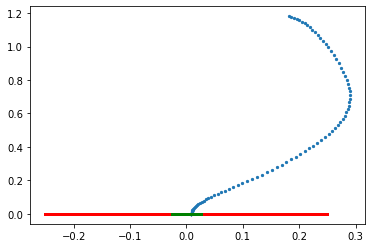

[98] loss: 0.000


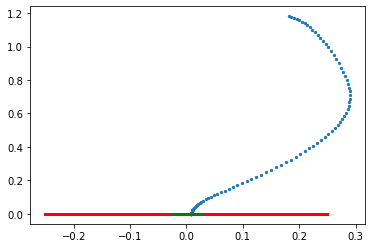

[99] loss: 0.000


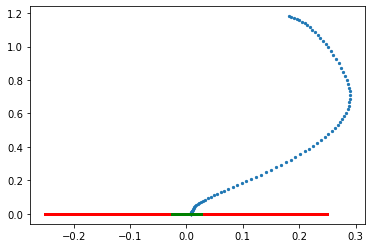

[100] loss: 0.000


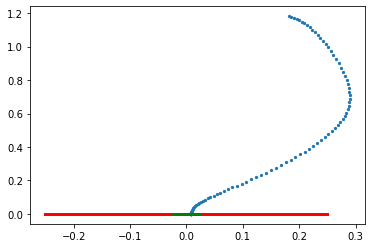

[101] loss: 0.000


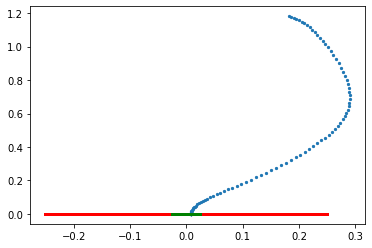

[102] loss: 0.000


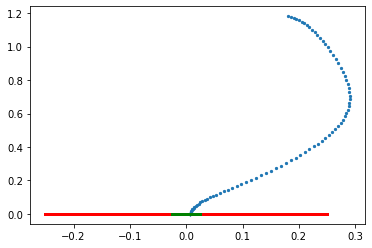

[103] loss: 0.000


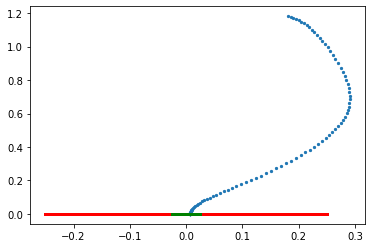

[104] loss: 0.000


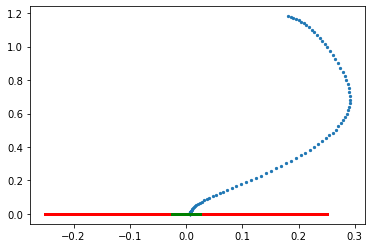

[105] loss: 0.000


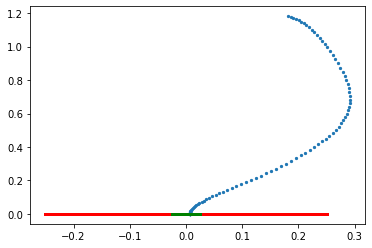

[106] loss: 0.000


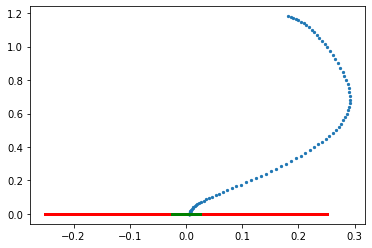

[107] loss: 0.000


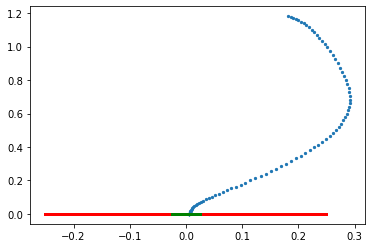

[108] loss: 0.000


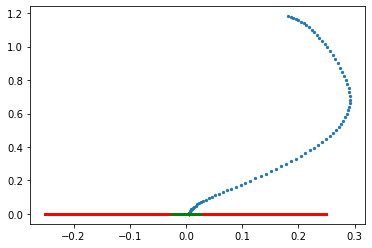

[109] loss: 0.000


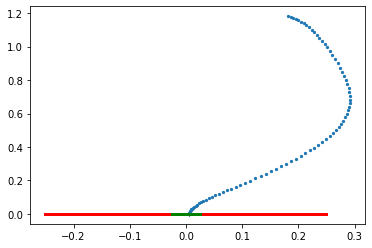

[110] loss: 0.000


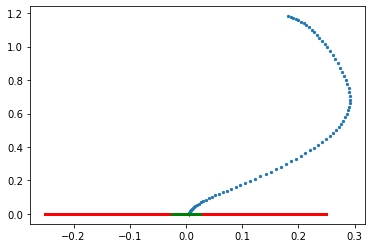

[111] loss: 0.000


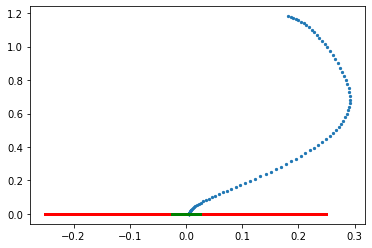

[112] loss: 0.000


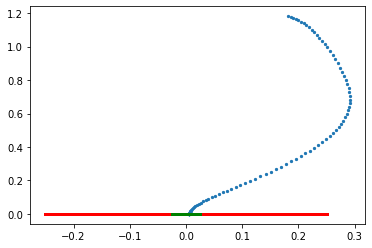

[113] loss: 0.000


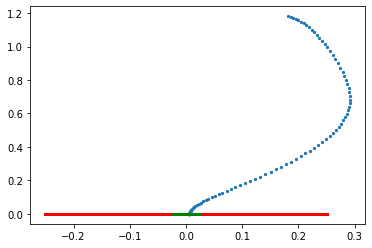

[114] loss: 0.000


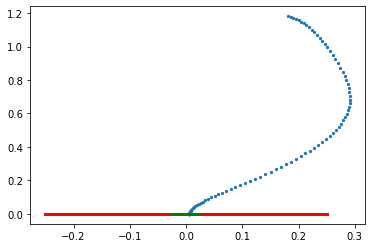

[115] loss: 0.000


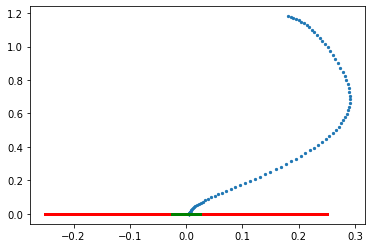

[116] loss: 0.000


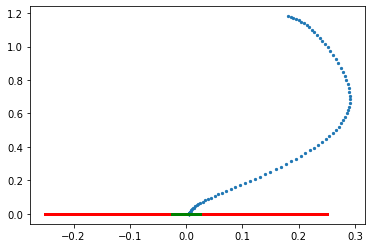

[117] loss: 0.000


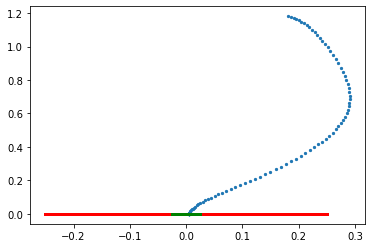

[118] loss: 0.000


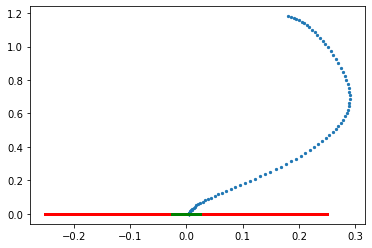

Landing Trajectory:


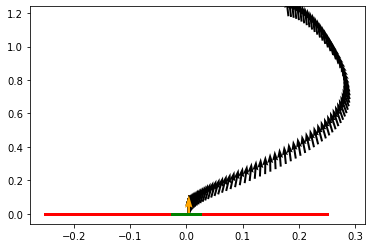

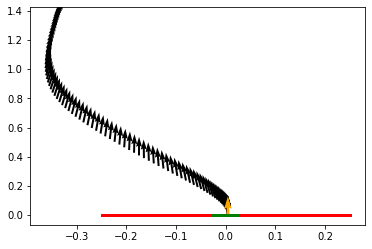

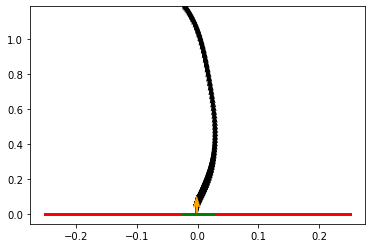

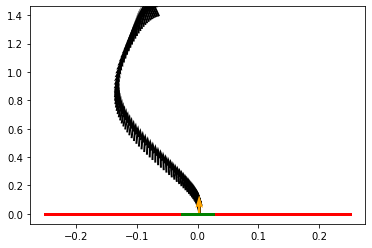

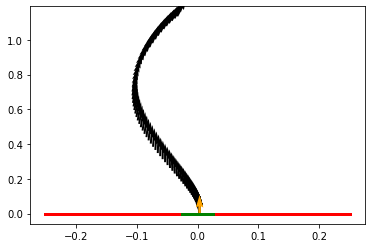

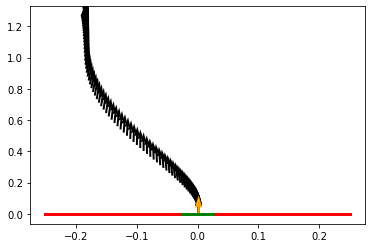

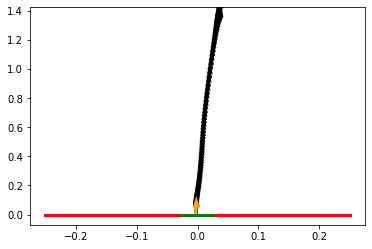

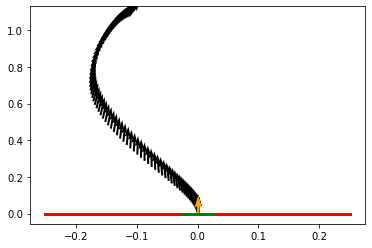

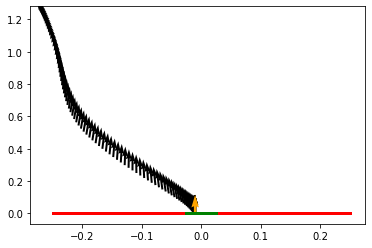

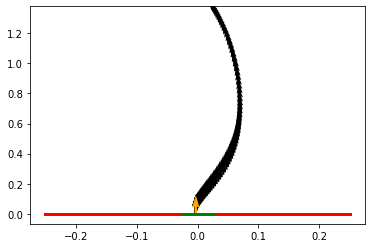

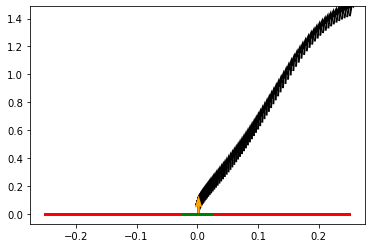

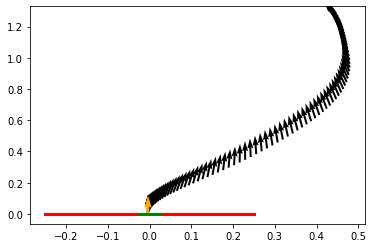

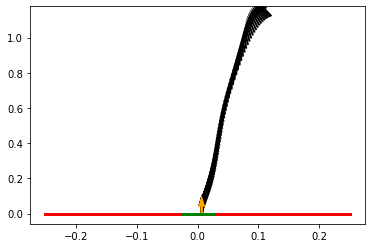

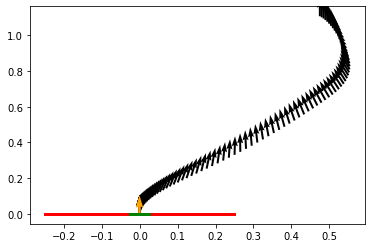

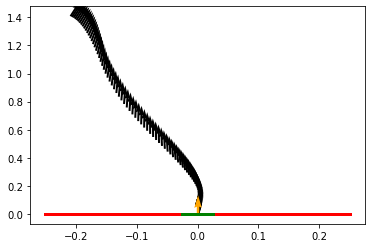

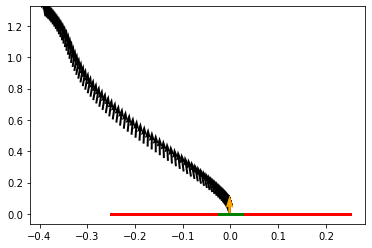

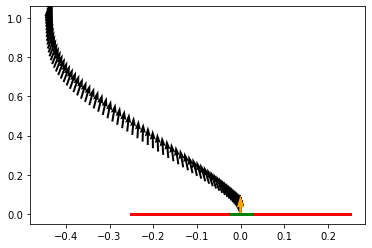

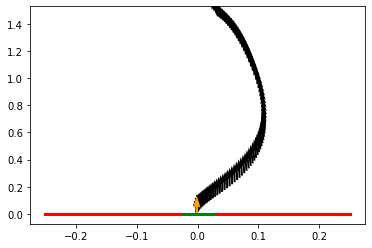

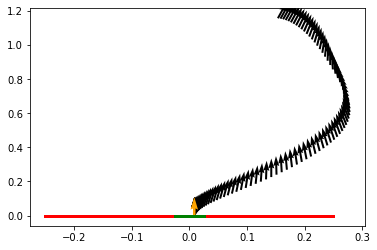

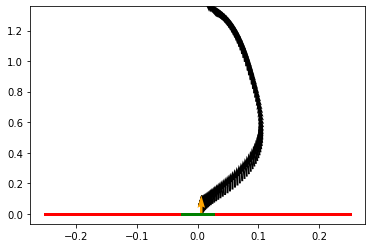

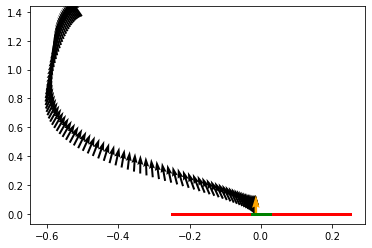

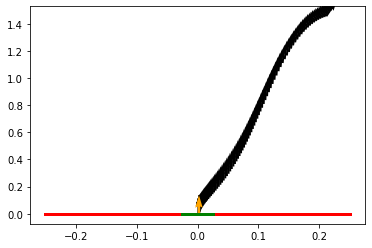

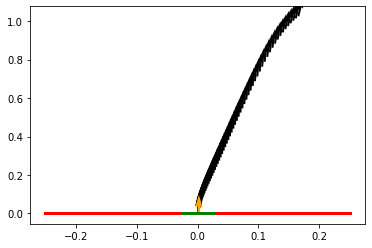

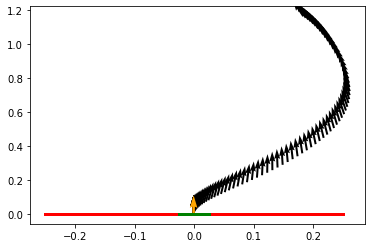

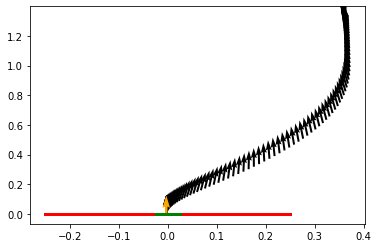

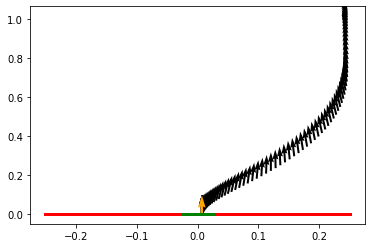

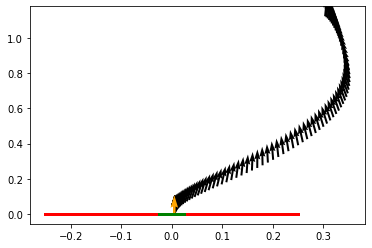

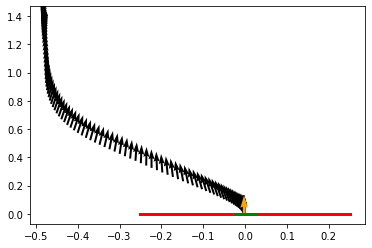

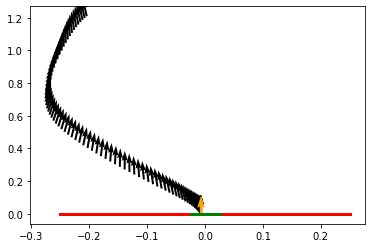

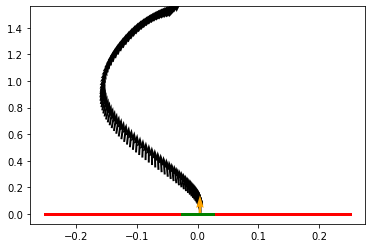

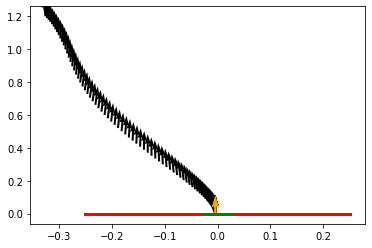

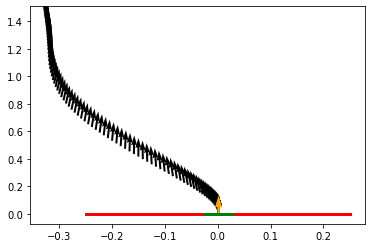

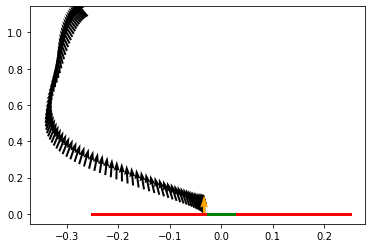

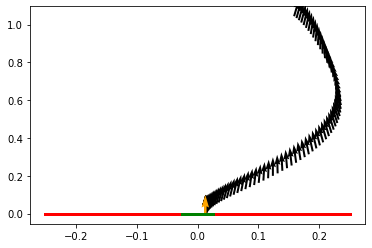

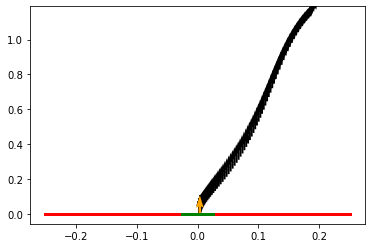

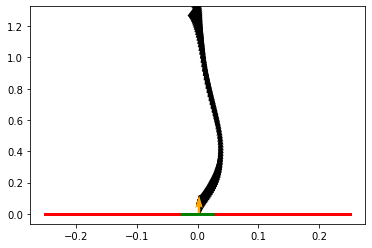

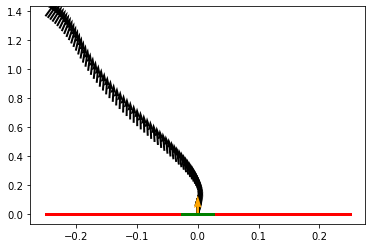

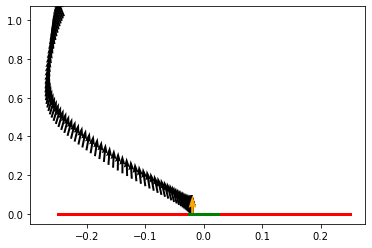

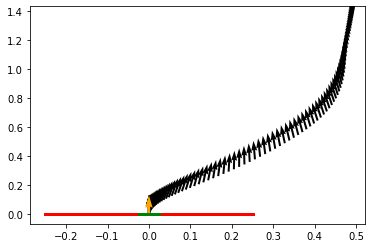

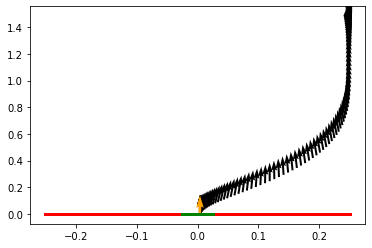

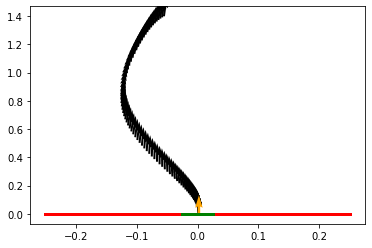

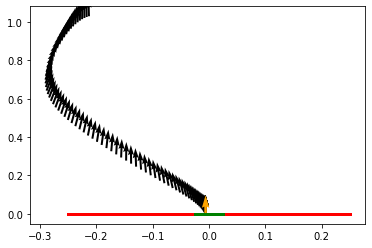

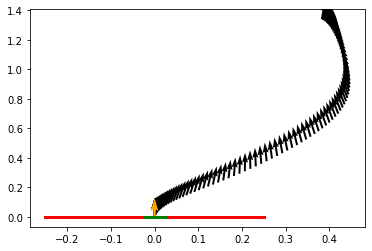

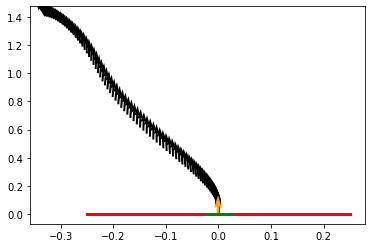

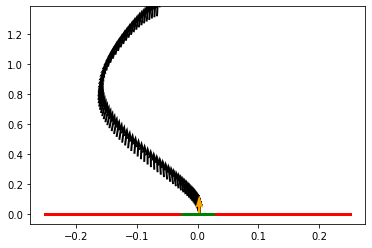

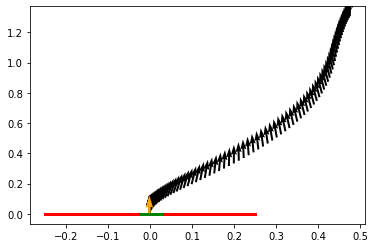

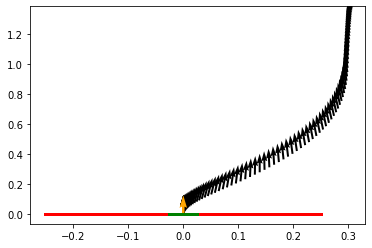

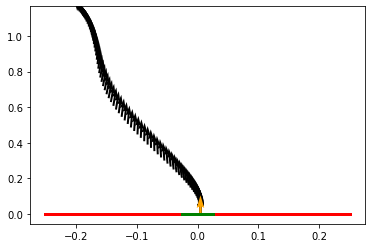

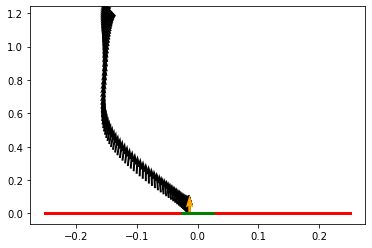

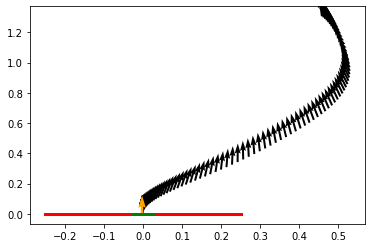

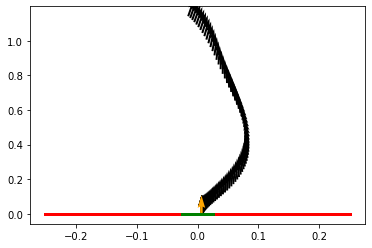

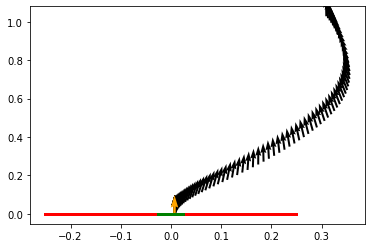

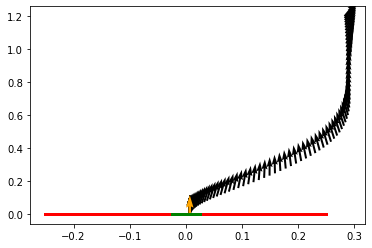

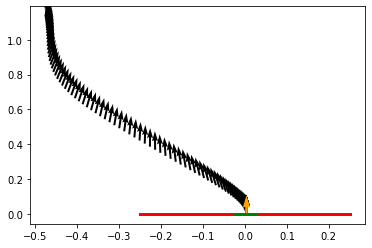

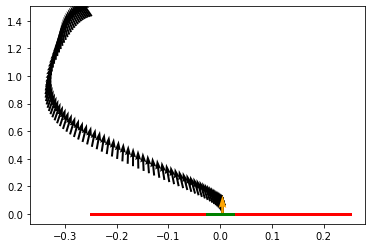

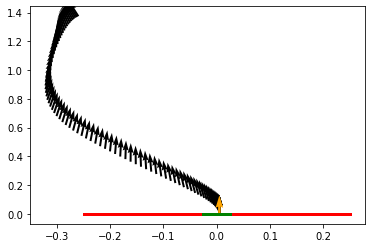

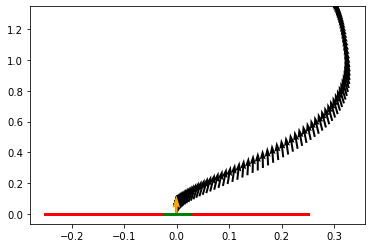

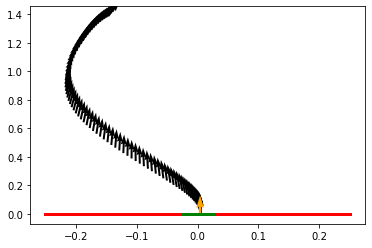

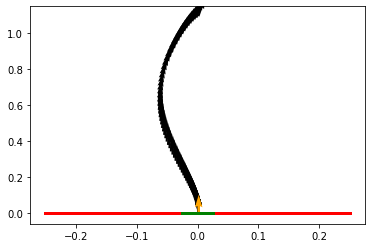

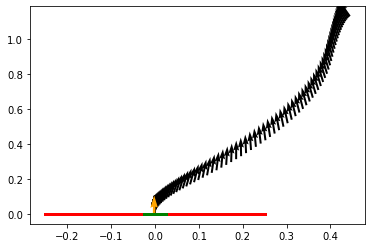

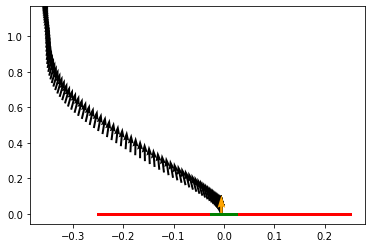

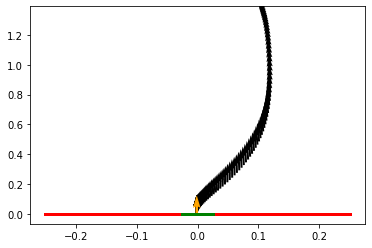

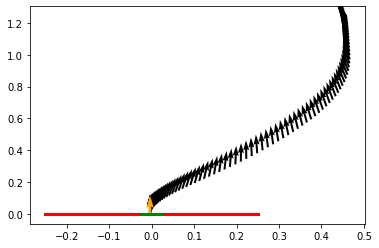

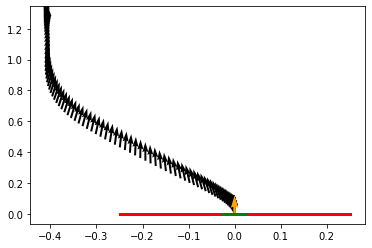

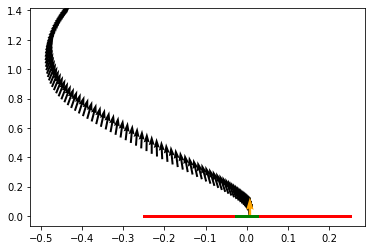

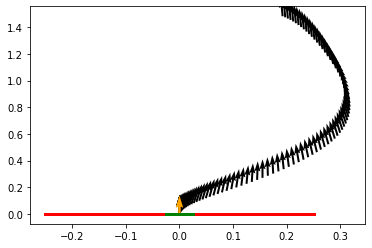

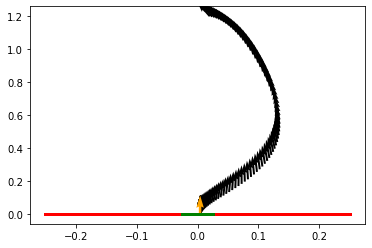

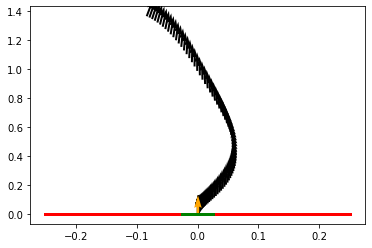

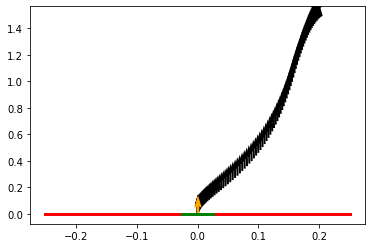

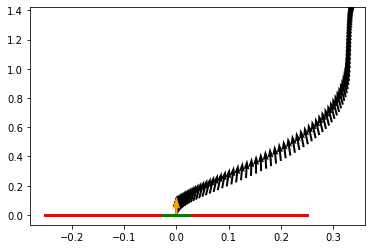

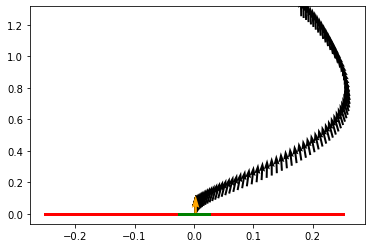

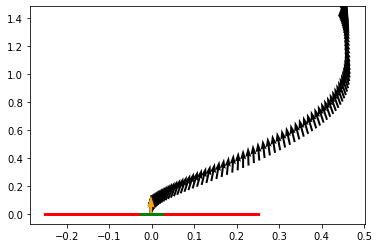

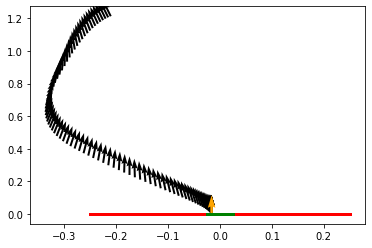

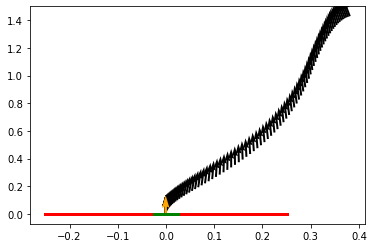

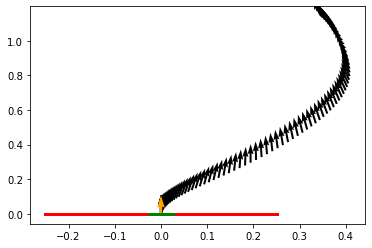

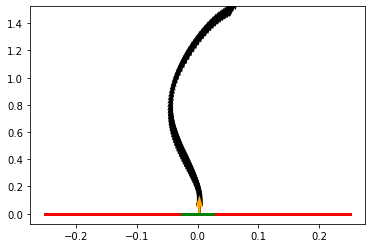

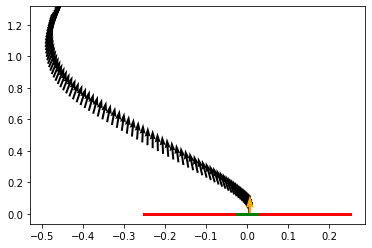

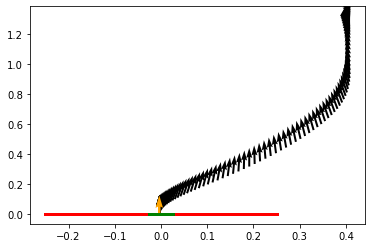

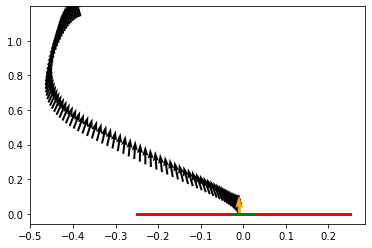

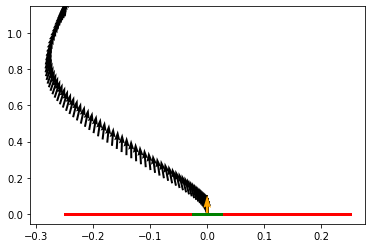

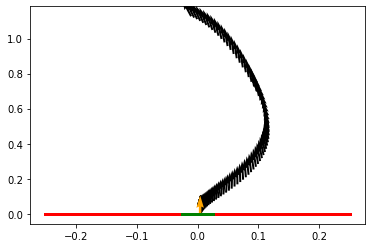

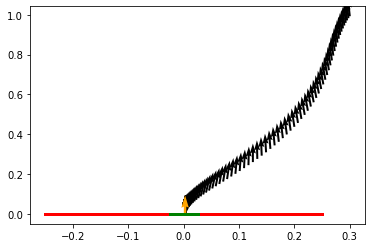

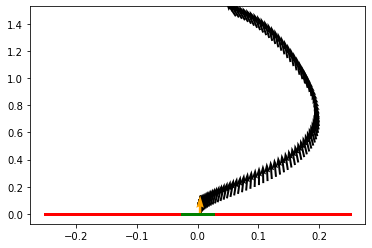

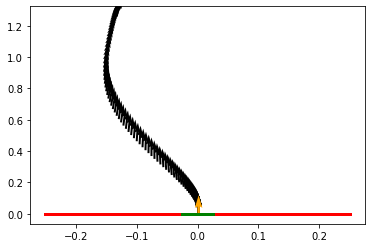

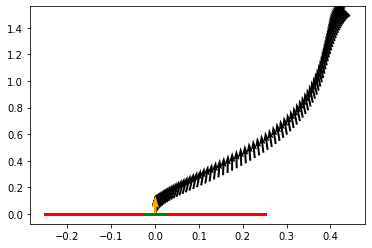

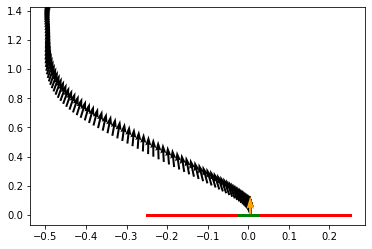

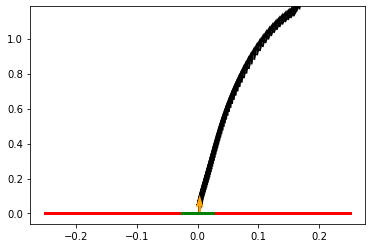

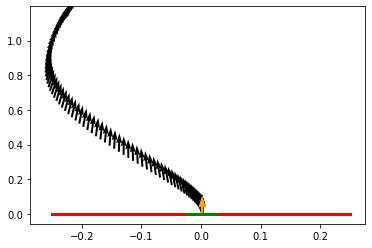

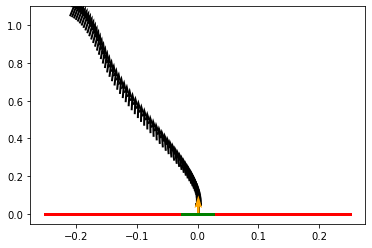

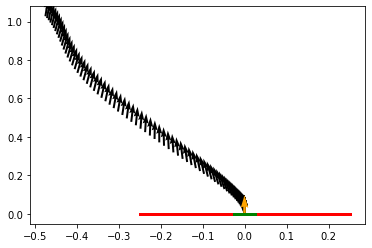

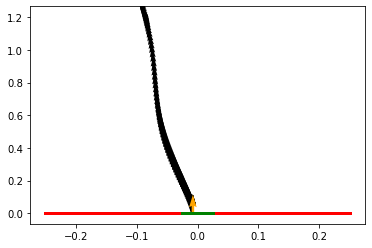

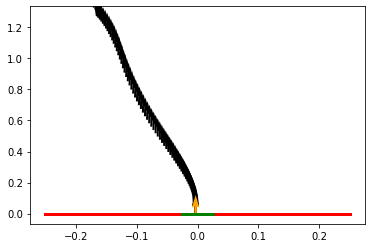

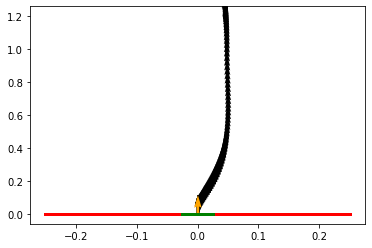

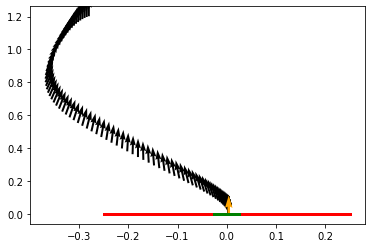

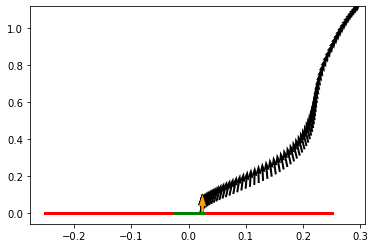

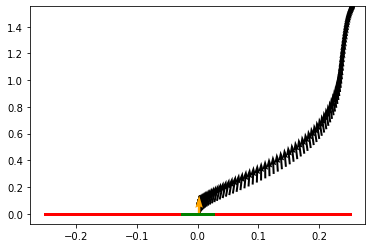

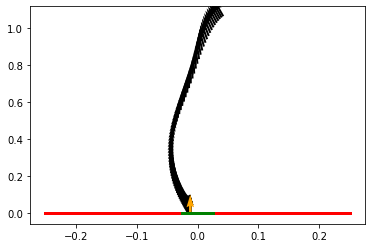

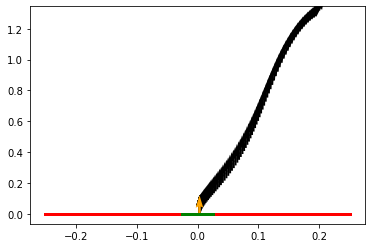

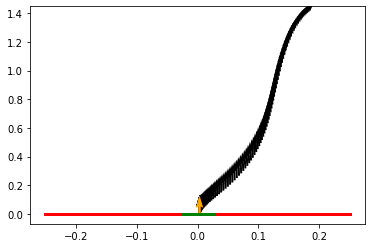

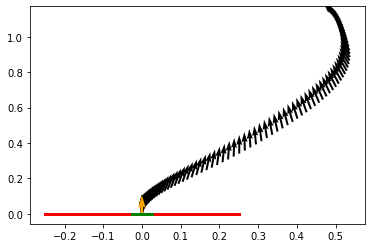

Convergence Plot:


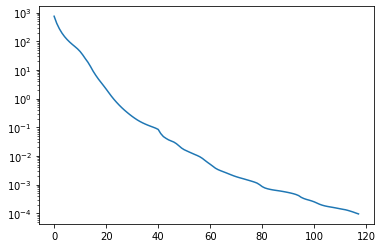

In [269]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.0001 # acceptable_error
itr = 120 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr)  # solve the optimization problem

path = './Landing_Model.pth'
t.save(c.state_dict(),path)
